# The control of human psycho-affective stability using differential equations

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sp

# Functions 

### Define the system

In [3]:
def romeo_juliet_system(t, variables, a, b, c, d):
    """
    Defines the linear system modeling Romeo and Juliet's emotions.
    dx/dt = a*x + b*y
    dy/dt = c*x + d*y
    """
    x, y = variables
    dxdt = a * x + b * y
    dydt = c * x + d * y
    return [dxdt, dydt]

### Equilibrium and stability computations

In [4]:
def analyze_stability(a, b, c, d):
    """
    Computes the Jacobian matrix, trace, determinant, discriminant, eigenvalues,
    and interprets stability (stable/unstable node, spiral, center, saddle, etc.).
    Also prints the symbolic analytical solution (x(t), y(t)).
    """

    print("\n===== STABILITY ANALYSIS =====")

    # --- Jacobian matrix ---
    J = np.array([[a, b], [c, d]], dtype=float)
    tau = a + d
    delta = np.linalg.det(J)
    discriminant = tau**2 - 4 * delta
    eigenvalues, _ = np.linalg.eig(J)

    print(f"Jacobian matrix:\n{J}")
    print(f"Trace τ = {tau:.4f}")
    print(f"Determinant Δ = {delta:.4f}")
    print(f"Discriminant 𝓓 = {discriminant:.4f}")

    if not np.isclose(delta, 0, atol=1e-10):
        print("→ One unique equilibrium point: (0, 0)")
    else:
        print("→ Infinite or no equilibrium points (det(A)=0).")

    print(f"Eigenvalues λ₁,₂ = {eigenvalues}\n")

    # --- Stability classification ---
    if np.iscomplex(eigenvalues).any():
        # Complex conjugate eigenvalues
        real_part = np.real(eigenvalues[0])
        imag_part = np.imag(eigenvalues[0])

        if np.isclose(real_part, 0, atol=1e-8) and not np.isclose(imag_part, 0, atol=1e-8):
            stability = "Center (neutral oscillations)"
        elif real_part < 0:
            stability = "STABLE spiral"
        elif real_part > 0:
            stability = "UNSTABLE spiral"
        else:
            stability = "Oscillatory (indeterminate)"
    else:
        # Real eigenvalues
        λ1, λ2 = np.real(eigenvalues[0]), np.real(eigenvalues[1])

        if np.isclose(λ1, λ2, atol=1e-8):
            if λ1 < 0:
                stability = "STABLE degenerate node"
            elif λ1 > 0:
                stability = "UNSTABLE degenerate node"
            else:
                stability = "Neutral degenerate node (λ = 0)"
        elif λ1 < 0 and λ2 < 0:
            stability = "STABLE node"
        elif λ1 > 0 and λ2 > 0:
            stability = "UNSTABLE node"
        elif λ1 * λ2 < 0:
            stability = "SADDLE point (unstable)"
        else:
            stability = "Indeterminate case"

    print(f"→ Stability type: {stability}\n")

    # --- Symbolic solution using SymPy ---
    print("🔹 Symbolic solution (using SymPy):")

    t = sp.Symbol('t', real=True)
    x = sp.Function('x')(t)
    y = sp.Function('y')(t)

    eq1 = sp.Eq(sp.diff(x, t), a*x + b*y)
    eq2 = sp.Eq(sp.diff(y, t), c*x + d*y)

    try:
        sol = sp.dsolve([eq1, eq2])
        for s in sol:
            lhs = str(s.lhs)
            rhs = sp.simplify(s.rhs)
            print(f"{lhs} = {rhs}")
    except Exception as e:
        print("  Could not compute symbolic solution automatically.")
        print("  Error:", e)

    return stability

### Function to modelise/simulate

In [5]:
def simulate_system(a, b, c, d, x0, y0):
    """
    Solves the system numerically 
    """
    t_span = (0, 100)
    t_eval = np.linspace(*t_span, 500)
    sol = solve_ivp(romeo_juliet_system, t_span, [x0, y0], args=(a, b, c, d), t_eval=t_eval)
    print(f"Solution at time 100: x(100)={sol.y[0, -1]:.3f}, y(100)={sol.y[1, -1]:.3f}")

    
    return sol

### The function to plot

In [6]:
def plot_evolution(sol, title):
    """
    Plots the emotional evolution of Romeo and Juliet over time.
    """
    plt.figure(figsize=(6, 6))
    plt.plot(sol.t, sol.y[0], color='blue')
    plt.plot(sol.t, sol.y[1], color='red')

    plt.xlabel("Time")
    plt.ylabel("Emotions")
    plt.title(title, fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### The function to plot plan phase

In [7]:
def plot_phase(a, b, c, d, title):
    """
    Plots the phase portrait of the system for various initial conditions.
    1. Computes the equilibrium point.
    2. Generates a grid of initial conditions around the equilibrium.
    3. Integrates the system forward and backward in time for each initial condition.
    4. Plots the trajectories in the phase space.
    """
    box = 0.2
    t_span = (0, 100)
    t_eval = np.linspace(*t_span, 250)
    eps = 1e-4
    points = np.linspace(-box, box, 6)

    # --- Equilibrium point calculation ---
    A = np.array([[a, b], [c, d]])
    detA = np.linalg.det(A)

    if abs(detA) < 1e-10:
        x_eq, y_eq = 0.0, 0.0
        print("⚠  No unique equilibrium — using (0,0) for plotting")
    else:
        x_eq, y_eq = 0.0, 0.0

    initials = []
    for x in points:
        for y in points:
            xi = x_eq + x + np.random.uniform(-eps, eps)
            yi = y_eq + y + np.random.uniform(-eps, eps)
            if np.isfinite(xi) and np.isfinite(yi) and (abs(xi) > 0.01 or abs(yi) > 0.01):
                initials.append((xi, yi))

    if len(initials) == 0:
        initials = [(0.1, 0.1)]

    plt.figure(figsize=(6, 6))

    for x_init, y_init in initials:
        try:
            sol_fwd = solve_ivp(romeo_juliet_system, t_span, [x_init, y_init],
                                args=(a, b, c, d), t_eval=t_eval,
                                rtol=1e-8, atol=1e-8)
            if sol_fwd.success:
                plt.plot(sol_fwd.y[0], sol_fwd.y[1], color='b', lw=1.2, alpha=0.8)
        except Exception:
            pass

        # backward integration 
        try:
            sol_bwd = solve_ivp(romeo_juliet_system, (0, -100), [x_init, y_init],
                                args=(a, b, c, d), t_eval=-t_eval,
                                rtol=1e-8, atol=1e-8)
            if sol_bwd.success:
                plt.plot(sol_bwd.y[0], sol_bwd.y[1], color='b', lw=1.2, alpha=0.6)
        except Exception:
            pass

    # --- Equilibrium point plotting ---
    plt.scatter(x_eq, y_eq, color='black', s=50,
                label=f'Equilibrium (xₑ={x_eq:.2f}, yₑ={y_eq:.2f})')

    plt.legend(loc="upper right", frameon=True, facecolor='white')
    plt.xlim(-box, box)
    plt.ylim(-box, box)
    plt.xlabel("x")
    plt.ylabel("y", rotation=0)
    plt.title(title, fontsize=16)
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    plt.show()

### THE function

In [8]:
def run_scenario(name, a, b, c, d, x0, y0, box=0.2):
    """
    Runs one full scenario: stability + simulation + plot.
    """
    print("\n----------------------------------------")
    print(f"SCENARIO: {name}")
    print(f"Parameters: a={a}, b={b}, c={c}, d={d}")
    
    stability = analyze_stability(a, b, c, d)
    
    sol = simulate_system(a, b, c, d, x0, y0)
    
    plot_evolution(sol, f"a={a}, b={b}, c={c}, d={d}")
    plot_phase(a, b, c, d, f" a={a}, b={b}, c={c}, d={d} - {stability}")

How to use it : copy and paste the following code :


In [9]:
#scenarios = {
#    "scenario 1": (0, 0, 0, 0),
#    "scenario 2": (0, 0, 0, 0),
#    } # Add scenarios as needed

# Run them all
#for name, params in scenarios.items():
#    run_scenario(name, *params, x0=0.1, y0=0.1)

# Test

Parameters **_a_**, **_b_**, **_c_**, **_d_** quantify Romeo’s romantic style and Juliet's romantic style as follows :


- **_a_** --> how Romeo is encouraged by his feelings
- **_b_** --> how Romeo is encouraged by Juliet’s feelings.
- **_c_** --> how Juliet is encouraged by Romeo's feelings 
- **_d_** --> how Juliet is encouraged by her feelings


## Mutual and increasing love scenarios



----------------------------------------
SCENARIO: Figure 1
Parameters: a=0, b=0.2, c=0.05, d=0

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[0.   0.2 ]
 [0.05 0.  ]]
Trace τ = 0.0000
Determinant Δ = -0.0100
Discriminant 𝓓 = 0.0400
→ One unique equilibrium point: (0, 0)
Eigenvalues λ₁,₂ = [ 0.1 -0.1]

→ Stability type: SADDLE point (unstable)

🔹 Symbolic solution (using SymPy):
x(t) = 2.0*(-C1 + C2*exp(0.2*t))*exp(-0.1*t)
y(t) = 1.0*(C1 + C2*exp(0.2*t))*exp(-0.1*t)
Solution at time 100: x(100)=3302.548, y(100)=1651.274


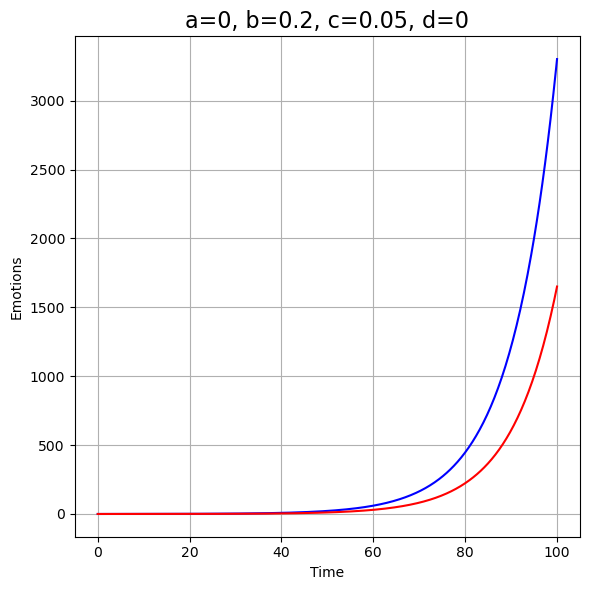

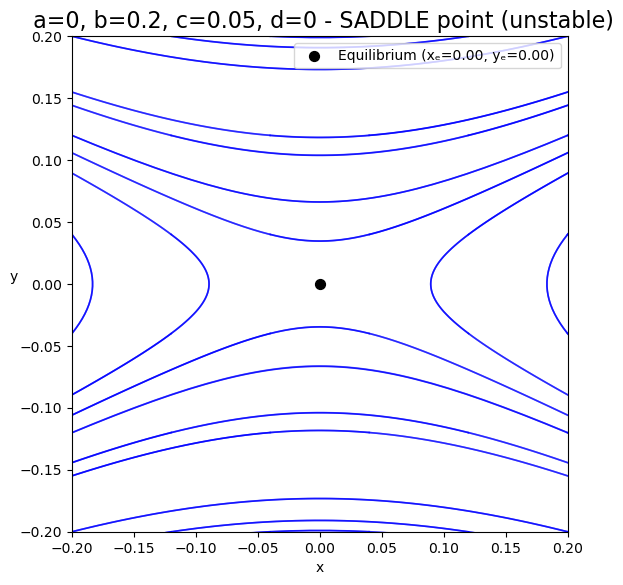


----------------------------------------
SCENARIO: Figure 2
Parameters: a=0, b=0.2, c=0.1, d=0

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[0.  0.2]
 [0.1 0. ]]
Trace τ = 0.0000
Determinant Δ = -0.0200
Discriminant 𝓓 = 0.0800
→ One unique equilibrium point: (0, 0)
Eigenvalues λ₁,₂ = [ 0.14142136 -0.14142136]

→ Stability type: SADDLE point (unstable)

🔹 Symbolic solution (using SymPy):
x(t) = 1.4142135623731*(-C1 + C2*exp(0.282842712474619*t))*exp(-0.14142135623731*t)
y(t) = 1.0*(C1 + C2*exp(0.282842712474619*t))*exp(-0.14142135623731*t)
Solution at time 100: x(100)=167201.208, y(100)=118229.108


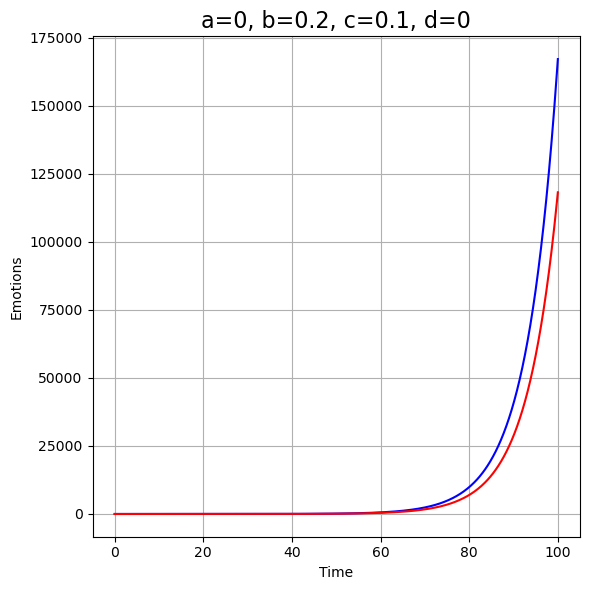

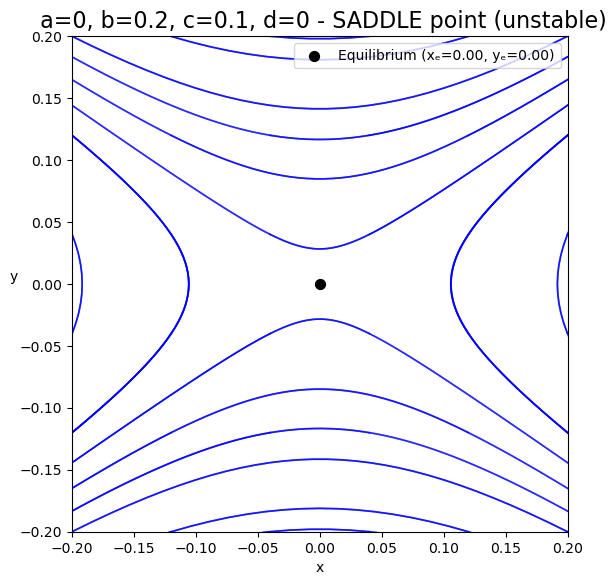


----------------------------------------
SCENARIO: Mutual and increasing love
Parameters: a=0, b=0.2, c=0.18, d=0

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[0.   0.2 ]
 [0.18 0.  ]]
Trace τ = 0.0000
Determinant Δ = -0.0360
Discriminant 𝓓 = 0.1440
→ One unique equilibrium point: (0, 0)
Eigenvalues λ₁,₂ = [ 0.18973666 -0.18973666]

→ Stability type: SADDLE point (unstable)

🔹 Symbolic solution (using SymPy):
x(t) = 1.05409255338946*(-C1 + C2*exp(0.379473319220205*t))*exp(-0.189736659610103*t)
y(t) = 1.0*(C1 + C2*exp(0.379473319220205*t))*exp(-0.189736659610103*t)
Solution at time 100: x(100)=17833578.479, y(100)=16918418.048


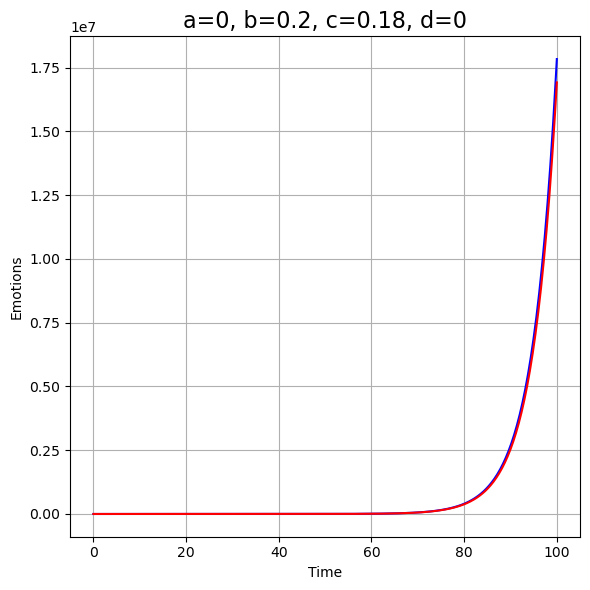

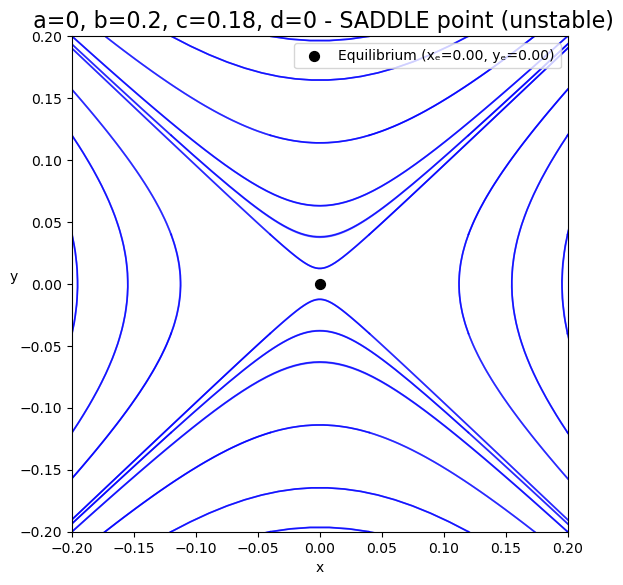


----------------------------------------
SCENARIO: case two
Parameters: a=1, b=1, c=1, d=1

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[1. 1.]
 [1. 1.]]
Trace τ = 2.0000
Determinant Δ = 0.0000
Discriminant 𝓓 = 4.0000
→ Infinite or no equilibrium points (det(A)=0).
Eigenvalues λ₁,₂ = [2. 0.]

→ Stability type: Indeterminate case

🔹 Symbolic solution (using SymPy):
x(t) = -C1 + C2*exp(2*t)
y(t) = C1 + C2*exp(2*t)
Solution at time 100: x(100)=71096077577711794700717404459889341046053507827282561868265869810661888205368810536960.000, y(100)=71096077577711794700717404459889341046053507827282561868265869810661888205368810536960.000


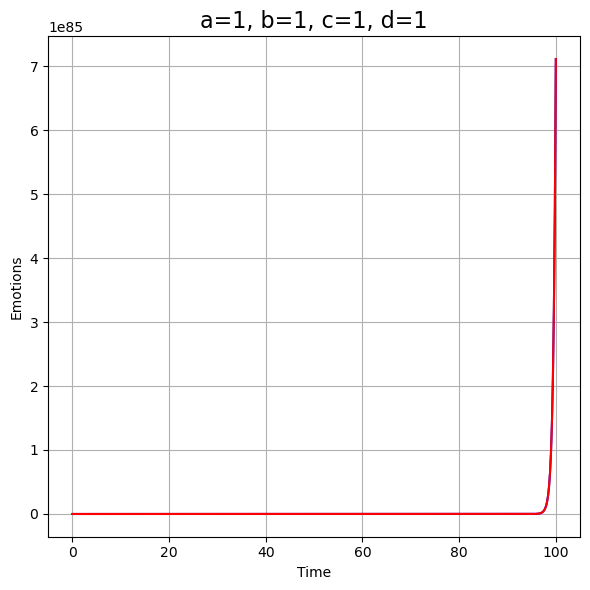

⚠  No unique equilibrium — using (0,0) for plotting


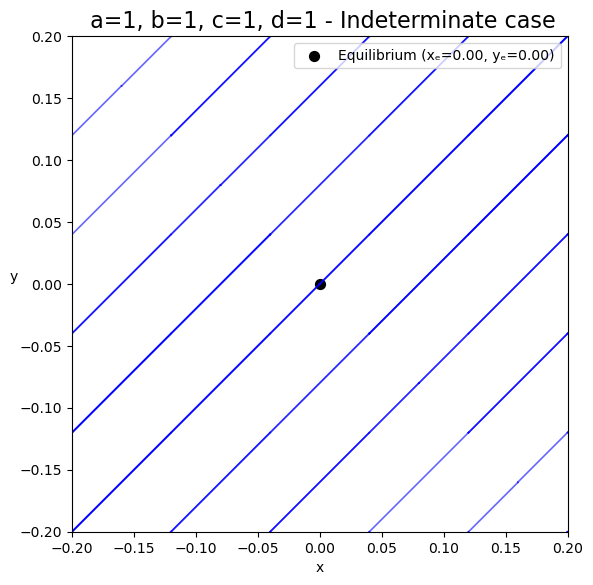

In [10]:
scenarios = {
    "Figure 1": (0, 0.2, 0.05, 0),
    "Figure 2": (0, 0.2, 0.1, 0),
    "Mutual and increasing love": (0, 0.2, 0.18, 0),
    "case two": (1, 1, 1, 1)
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=0.1, y0=0.1)


----------------------------------------
SCENARIO: case two
Parameters: a=1, b=1, c=1, d=1

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[1. 1.]
 [1. 1.]]
Trace τ = 2.0000
Determinant Δ = 0.0000
Discriminant 𝓓 = 4.0000
→ Infinite or no equilibrium points (det(A)=0).
Eigenvalues λ₁,₂ = [2. 0.]

→ Stability type: Indeterminate case

🔹 Symbolic solution (using SymPy):
x(t) = -C1 + C2*exp(2*t)
y(t) = C1 + C2*exp(2*t)
Solution at time 100: x(100)=0.100, y(100)=-0.100


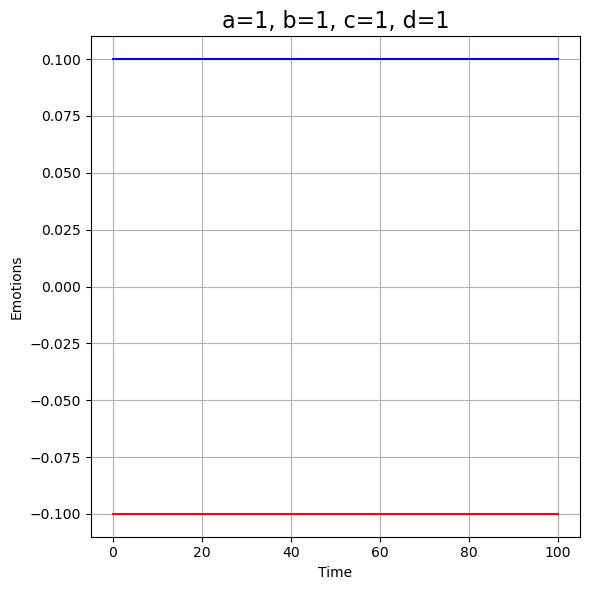

⚠  No unique equilibrium — using (0,0) for plotting


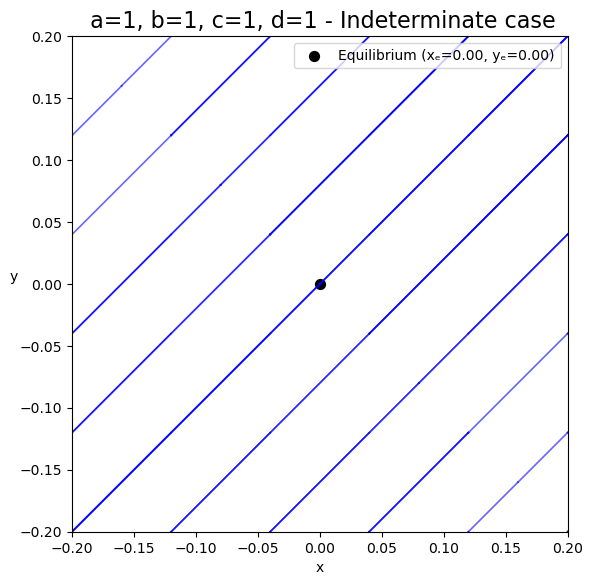

In [13]:
scenarios = {
    "case two": (1, 1, 1, 1)
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=0.1, y0=-0.1)

## Rollercoaster relationship


----------------------------------------
SCENARIO: Figure 3
Parameters: a=0, b=0.1, c=-0.1, d=0

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[ 0.   0.1]
 [-0.1  0. ]]
Trace τ = 0.0000
Determinant Δ = 0.0100
Discriminant 𝓓 = -0.0400
→ One unique equilibrium point: (0, 0)
Eigenvalues λ₁,₂ = [0.+0.1j 0.-0.1j]

→ Stability type: Center (neutral oscillations)

🔹 Symbolic solution (using SymPy):
x(t) = 1.0*C1*sin(0.1*t) + 1.0*C2*cos(0.1*t)
y(t) = 1.0*C1*cos(0.1*t) - 1.0*C2*sin(0.1*t)
Solution at time 100: x(100)=-1.384, y(100)=-0.291


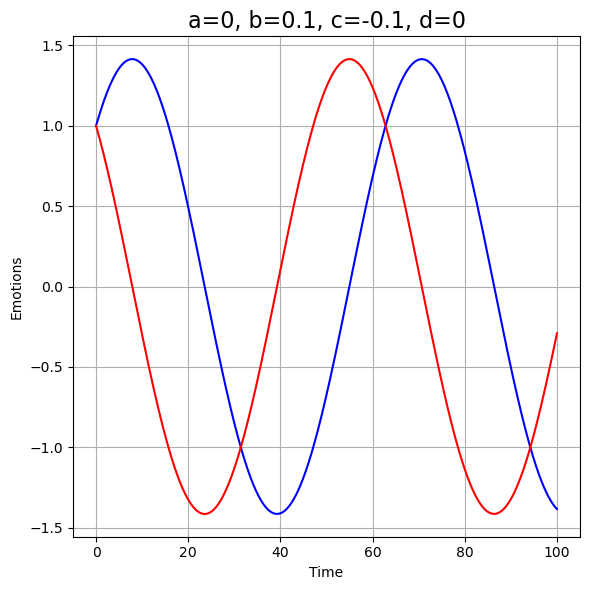

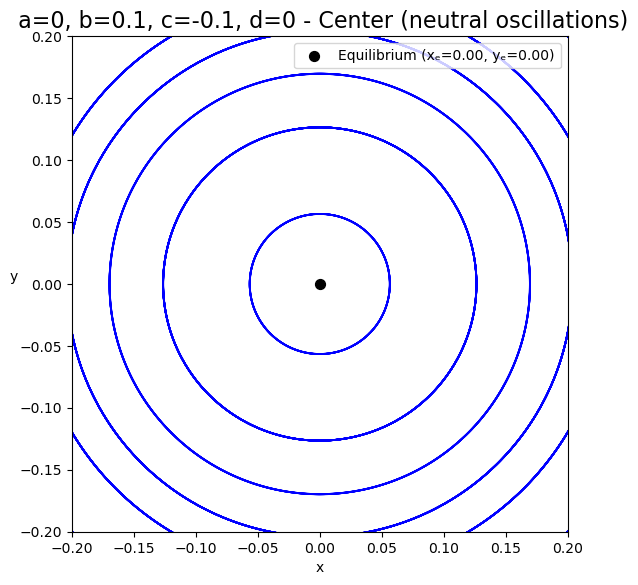

In [ ]:
scenarios = {
    "Figure 3": (0, 0.1, -0.1, 0),
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=1, y0=1)

## Unrequited love


----------------------------------------
SCENARIO: Figure 5
Parameters: a=0, b=-0.1, c=-0.2, d=0

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[ 0.  -0.1]
 [-0.2  0. ]]
Trace τ = 0.0000
Determinant Δ = -0.0200
Discriminant 𝓓 = 0.0800
→ One unique equilibrium point: (0, 0)
Eigenvalues λ₁,₂ = [ 0.14142136 -0.14142136]

→ Stability type: SADDLE point (unstable)

🔹 Symbolic solution (using SymPy):
x(t) = 0.707106781186548*(C1 - C2*exp(0.282842712474619*t))*exp(-0.14142135623731*t)
y(t) = 1.0*(C1 + C2*exp(0.282842712474619*t))*exp(-0.14142135623731*t)
Solution at time 100: x(100)=202873.111, y(100)=-286905.906


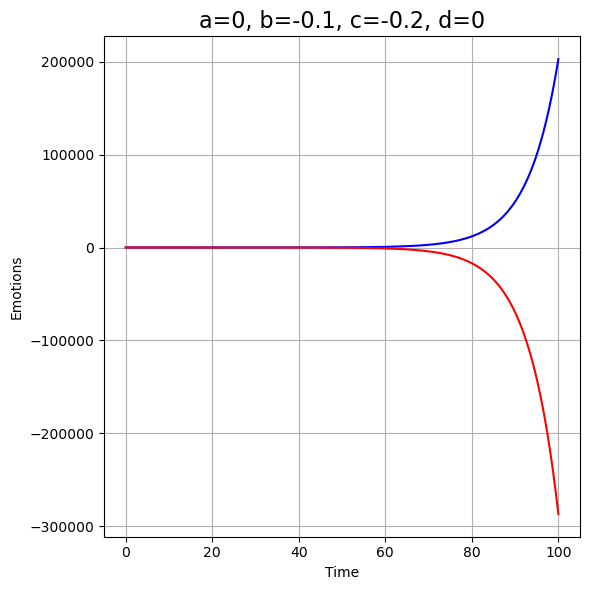

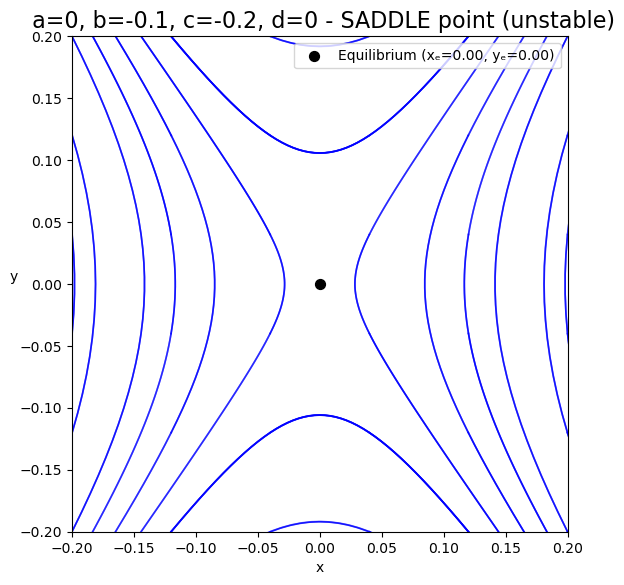


----------------------------------------
SCENARIO: case one
Parameters: a=-0.1, b=0, c=0, d=0.1

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[-0.1  0. ]
 [ 0.   0.1]]
Trace τ = 0.0000
Determinant Δ = -0.0100
Discriminant 𝓓 = 0.0400
→ One unique equilibrium point: (0, 0)
Eigenvalues λ₁,₂ = [-0.1  0.1]

→ Stability type: SADDLE point (unstable)

🔹 Symbolic solution (using SymPy):
x(t) = 1.0*C1*exp(-0.1*t)
y(t) = 1.0*C2*exp(0.1*t)
Solution at time 100: x(100)=0.000, y(100)=22030.234


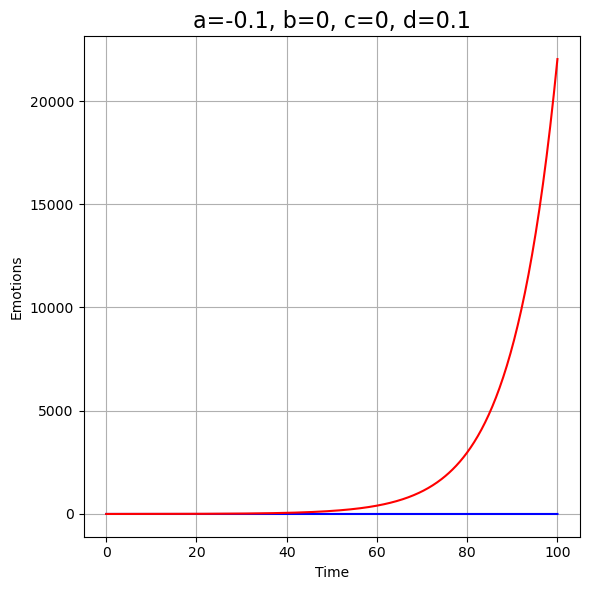

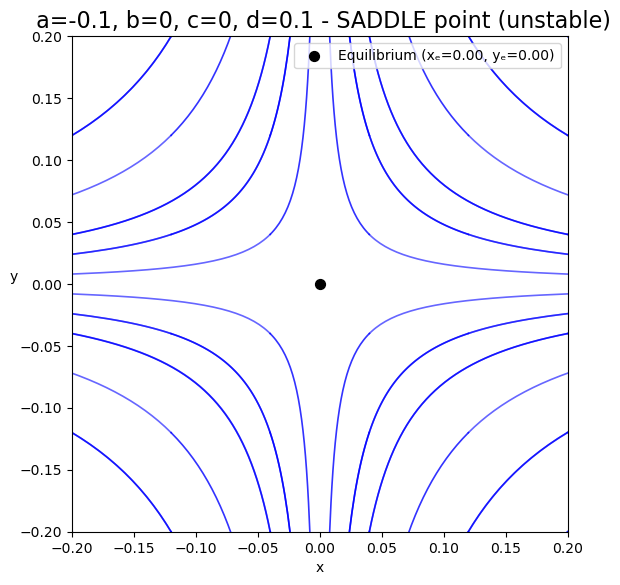

In [ ]:
scenarios = {
    "Figure 5": (0, -0.1, -0.2, 0),
    "case one": (-0.1, 0, 0, 0.1)
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=1, y0=1)

## Fading relationship


----------------------------------------
SCENARIO: Figure 6
Parameters: a=-0.3, b=0.3, c=0.4, d=-0.5

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[-0.3  0.3]
 [ 0.4 -0.5]]
Trace τ = -0.8000
Determinant Δ = 0.0300
Discriminant 𝓓 = 0.5200
→ One unique equilibrium point: (0, 0)
Eigenvalues λ₁,₂ = [-0.03944487 -0.76055513]

→ Stability type: STABLE node

🔹 Symbolic solution (using SymPy):
x(t) = -0.651387818865997*C1*exp(-0.760555127546399*t) + 1.151387818866*C2*exp(-0.0394448724536011*t)
y(t) = 1.0*C1*exp(-0.760555127546399*t) + 1.0*C2*exp(-0.0394448724536011*t)
Solution at time 100: x(100)=0.285, y(100)=0.247


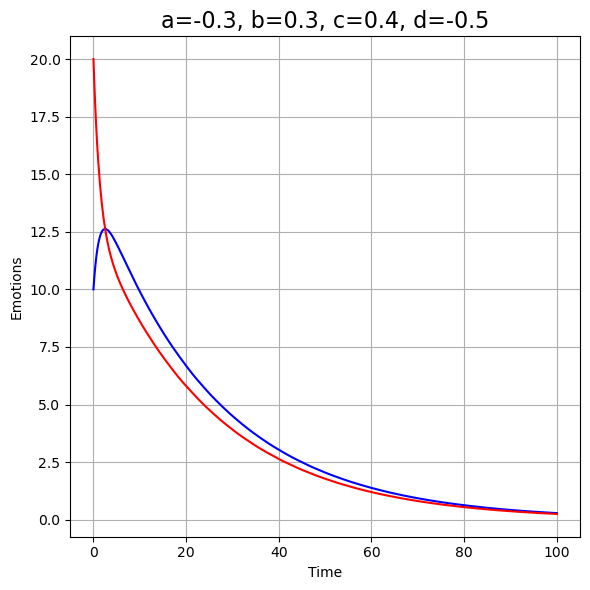

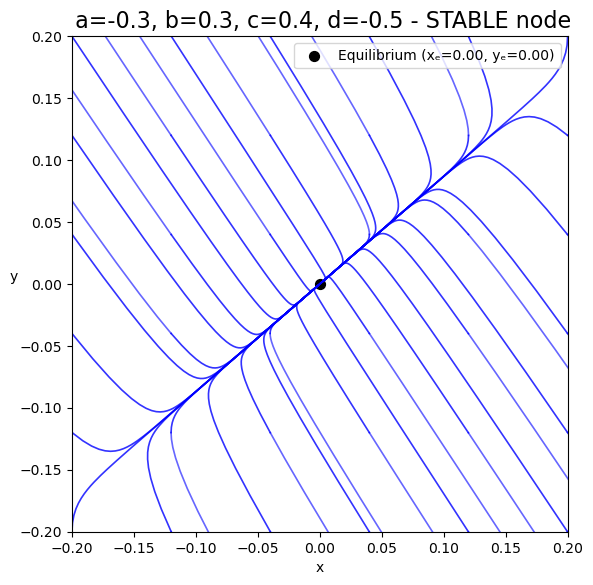

In [ ]:
scenarios = {
    "Figure 6": (-0.3, 0.3, 0.4, -0.5)
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=10, y0=20)

## A mutual and stable love



----------------------------------------
SCENARIO: a 'what could've been' love
Parameters: a=0, b=0, c=0, d=0

===== STABILITY ANALYSIS =====
Jacobian matrix:
[[0. 0.]
 [0. 0.]]
Trace τ = 0.0000
Determinant Δ = 0.0000
Discriminant 𝓓 = 0.0000
→ Infinite or no equilibrium points (det(A)=0).
Eigenvalues λ₁,₂ = [0. 0.]

→ Stability type: Neutral degenerate node (λ = 0)

🔹 Symbolic solution (using SymPy):
x(t) = C1
y(t) = C2
Solution at time 100: x(100)=10.000, y(100)=10.000


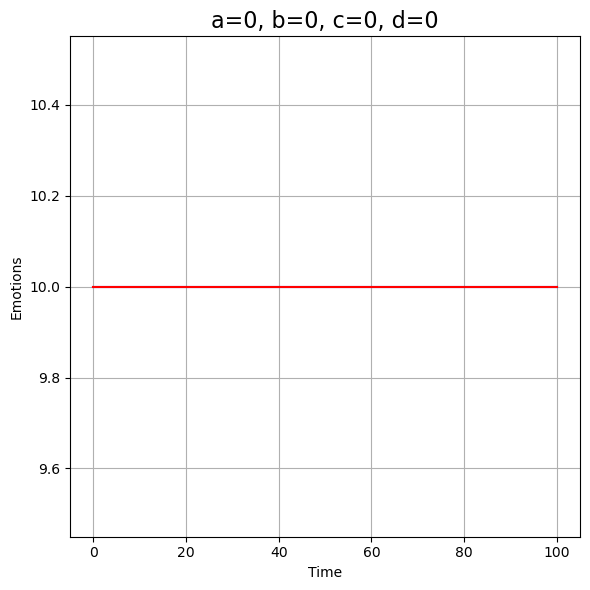

⚠  No unique equilibrium — using (0,0) for plotting


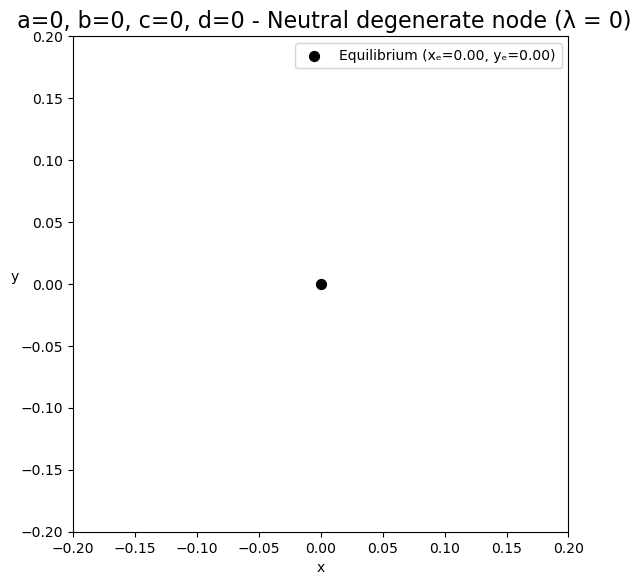

In [ ]:
scenarios = {
    "a 'what could've been' love": (0,0,0,0)
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=10, y0=10)